# Short-Term Technical Indicators Across Asset Classes: Implications for Allocation Decisions

**Course:** AM10 Data Visualisation – Final Group Project  

**Group 13**

**Goals:**  

1. Identify how short-term technical indicators behave across different asset classes and determine whether they exhibit consistent, exploitable patterns.

2. Translate these cross-asset technical signals into practical allocation insights that improve timing, risk management, and portfolio rotation decisions.

**Actions:**
1. ICE Data Manipulations

2. Constructing prediction models

In [129]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from sklearn.linear_model import LogisticRegression, LassoCV
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", 50)

# ICE data: Inspect, Clean and Explore

### Step1: Inspect data

Target: Check the data structure, and data type of each column of features. Check if there's any NULL or Duplicated items. Observe the distibution of data

In [130]:
# ----- adjust path to your CSV -----
data_path = r"D:\Dropbox\LBS\Term_1\AM10\final group project\data\multi_asset_market_data.csv"
df = pd.read_csv(data_path)
df.sort_values("date")

date final_price     asset       7d_avg      30d_avg  \
1640   2000-08-30       $4.93    silver     4.930000     4.930000   
41916  2000-08-30     $278.43      gold   272.358663   272.325462   
26074  2000-08-30     $273.90      gold   273.899994   273.899994   
39051  2000-08-30       $4.94    silver     4.957043     4.910079   
23534  2000-08-31       $5.00    silver     4.966500     4.966500   
...           ...         ...       ...          ...          ...   
3827   2025-11-02       $2.49    ripple     2.534450     2.560604   
47475  2025-11-02      $98.24  litecoin    97.597445   100.554088   
38000  2025-11-02       $2.53    ripple     2.543624     2.548528   
36884  2025-11-02    $3831.82  ethereum  3907.038331  4085.423860   
36484  2025-11-02    $3860.90  ethereum  3913.182303  4057.300277   

       daily_pct_change  volatility_7d  momentum_14d  trend_signal  \
1640           0.000000       0.000000           NaN             0   
41916          0.000000       0.000000           NaN             0   
26074          0.000000       0.000000           NaN             0   
39051          0.000000       0.000000           NaN             0   
23534          0.014807       0.051619           NaN             0   
...                 ...            ...           ...           ...   
3827          -0.004100       0.067723      0.104271             0   
47475         -0.031182       2.643409      4.956055             0   
38000         -0.003938       0.067293      0.104492             0   
36884         -0.003366     101.416452   -124.629769             0   
36484         -0.003431     106.579949   -123.754639             0   

       price_zscore  
1640            NaN  
41916           NaN  
26074           NaN  
39051           NaN  
23534      0.707107  
...             ...  
3827      -0.323679  
47475     -0.224981  
38000     -0.321884  
36884     -0.748855  
36484     -0.754609  

[50000 rows x 10 columns]

HEAD
         date final_price   asset      7d_avg     30d_avg  daily_pct_change  \
0  2008-07-22     $948.00    gold  964.371425  920.606667         -0.015679   
1  2006-03-20     $544.73    gold  553.832642  554.225797          0.001924   
2  2003-11-17     $391.50    gold  390.899998  382.076668         -0.015837   
3  2006-04-28     $651.80    gold  632.499991  594.233333          0.029212   
4  2005-05-20       $6.93  silver    7.010429    7.083333         -0.025983   

   volatility_7d  momentum_14d  trend_signal  price_zscore  
0      10.041208      5.500000             1      0.785980  
1       5.383550     -6.477138             0      0.280029  
2       5.136470      8.299988             1      1.260717  
3      10.939685     63.399963             1      1.930167  
4       0.104297      0.095000             0     -1.083492  

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column            Non-Null Count  

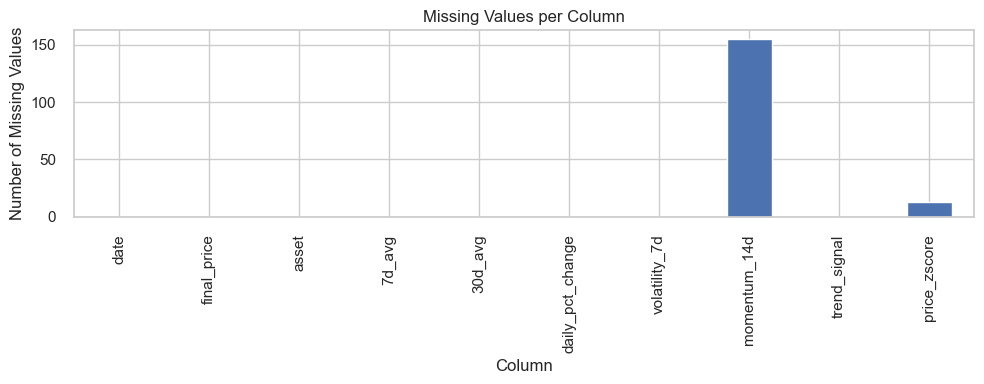

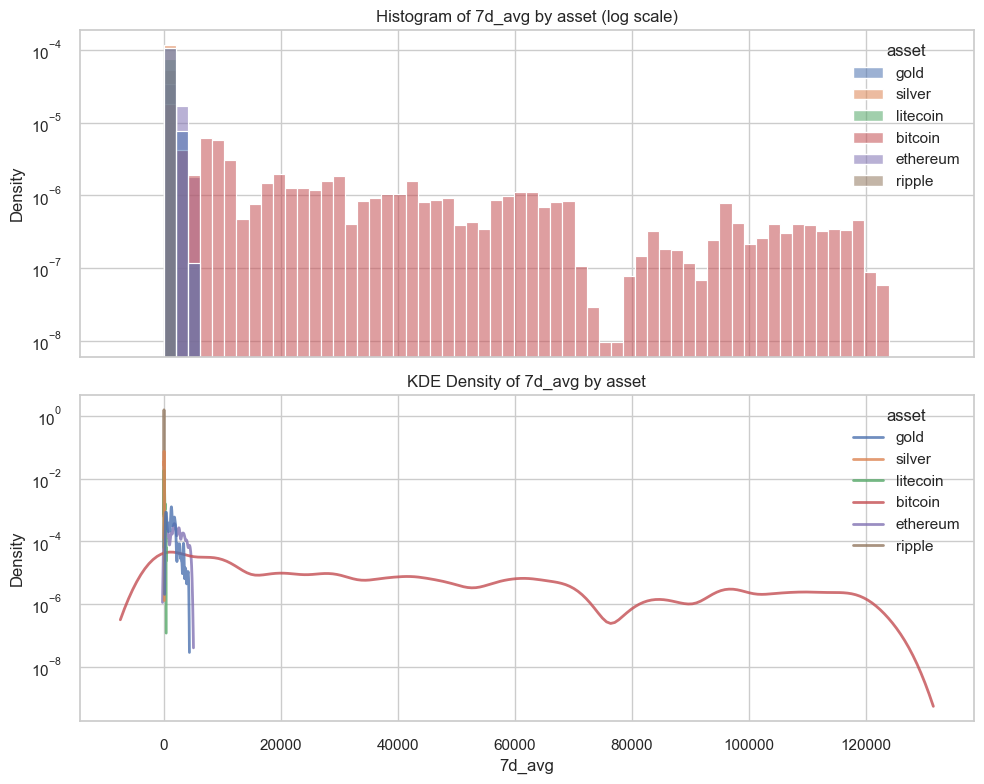

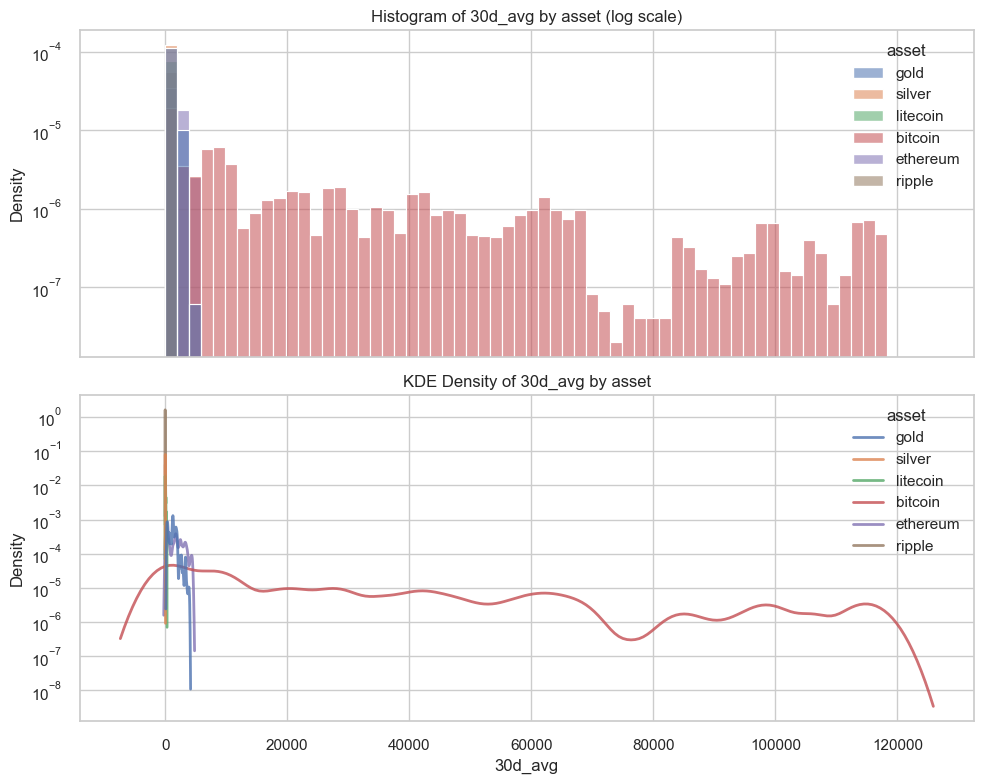

In [59]:
# Step 1: Inspect Data
# Data Info
print("HEAD")
print(df.head(5))          
print("\nINFO")
df.info()
print("\nDESCRIBE")
print(df.describe())

# Visualize the structure of raw data using Missing Values Bar Chart
missing_counts = df.isna().sum()
plt.figure(figsize=(10, 4))
missing_counts.plot(kind="bar")
plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Number of Missing Values")
plt.tight_layout()
plt.show()

# Check the Distribution of each column
# AKA Multi-Asset Distribution Visualisation
num_cols = df.select_dtypes(include="number").columns
hue_col = "asset"
sns.set(style="whitegrid")

for col in num_cols:

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    # Upper：Histogram
    sns.histplot(
        data=df,
        x=col,
        hue=hue_col,
        bins=60,
        stat="density",
        alpha=0.55,       
        ax=axes[0]
    )
    axes[0].set_title(f"Histogram of {col} by {hue_col} (log scale)")
    axes[0].set_ylabel("Density")
    axes[0].set_yscale("log")

    # Lower：KDE
    sns.kdeplot(
        data=df,
        x=col,
        hue=hue_col,
        alpha=0.8,       
        linewidth=2,
        bw_adjust=0.5,
        common_norm=False,
        ax=axes[1]
    )
    axes[1].set_title(f"KDE Density of {col} by {hue_col}")
    axes[1].set_xlabel(col)
    axes[1].set_ylabel("Density")
    axes[1].set_yscale("log")

    plt.tight_layout()
    plt.show()


#### Observations:
1. The histogram and KDE plots above illustrate that the distributions of numerical features vary by asset.
2. Many features display significant skew, with long tails; log-scaling helps reveal these differences.
3. Commodity and crypto assets can show distinct distribution patterns in variables such as momentum and volatility.
4. Some features have clusters or outliers that may be asset-specific.
5. The presence of missing values has also been visualized, showing that some columns have gaps which should be addressed in cleaning.

### Step 2: Clean Data

Target: Data Manipulations Measures

In [139]:
# date → datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# final_price to float if needed
if df["final_price"].dtype == object:
    df["final_price"] = (
        df["final_price"]
        .astype(str)
        .str.replace(r"[\$,]", "", regex=True)
        .astype(float)
    )

# drop rows with missing key columns
df = df.dropna(subset=["momentum_14d", "price_zscore"]).reset_index(drop=True)

# sort by asset & date
df = df.sort_values(["asset", "date"]).reset_index(drop=True)

# create future_return (next-day daily_pct_change per asset)
df["future_return"] = df.groupby("asset")["daily_pct_change"].shift(-1)
df = df.dropna(subset=["future_return"]).reset_index(drop=True)

# binary direction: 1 = up, 0 = flat/down
df["future_direction"] = (df["future_return"] > 0).astype(int)

# asset_class: Crypto vs Commodity
crypto = ["bitcoin", "ethereum", "litecoin", "ripple"]
commodities = ["gold", "silver"]

df["asset_class"] = df["asset"].str.lower().map(
    lambda x: "Crypto" if x in crypto else "Commodity"
)

df.head()

# Redo Step 1: check null or duplicates
# Visualize the structure of raw data using Missing Values Bar Chart
missing_counts = df.isna().sum()
plt.figure(figsize=(10, 4))
missing_counts.plot(kind="bar")
plt.title("Missing Values per Column")
plt.xlabel("Column")
plt.ylabel("Number of Missing Values")
plt.tight_layout()
plt.show()

Above shows a blank figure, So far so good

### Step 3: Explore Data

Target: 

1. Exploration of Multivariate Relationships (Correlation, Pairwise Relationships)

2. Grouped Statistics (by asset)

3. Basic Time Series Analysis

4. Visualisation of Key Features

In [65]:
num_cols = df.select_dtypes(include="number").columns
cat_cols = df.select_dtypes(include="object").columns
hue_col = "asset"

sns.set(style="whitegrid")

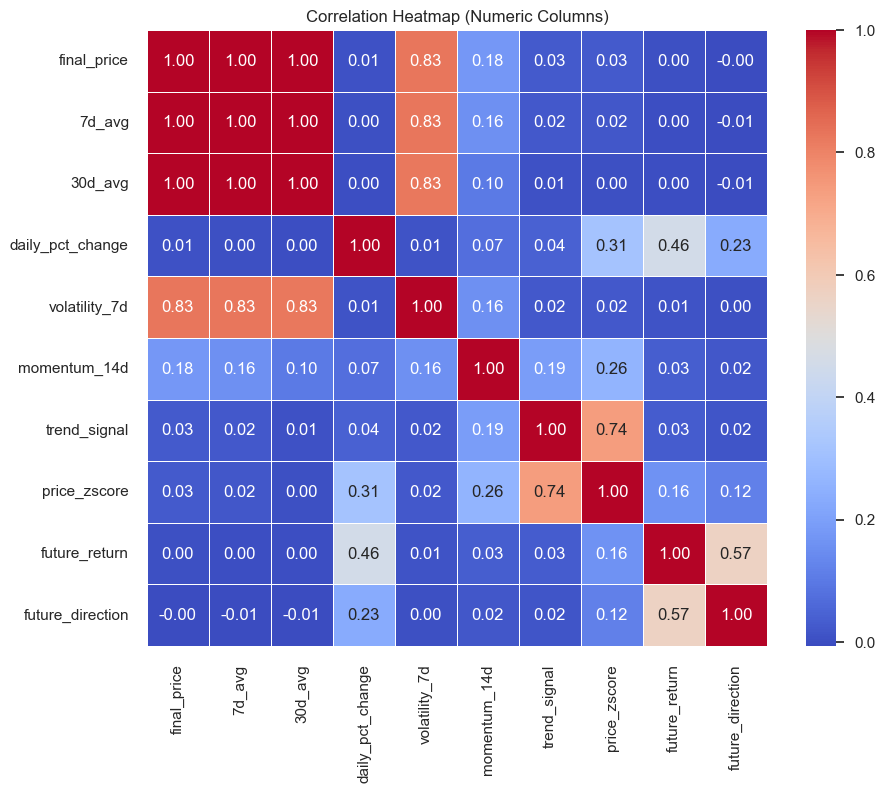

In [66]:
# Correlation Matrix
plt.figure(figsize=(10, 8))
corr = df[num_cols].corr()

sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap (Numeric Columns)")
plt.show()


#### Observations:
1. There is a strong positive correlation between '7d_avg' and '30d_avg', as expected since they both represent moving average price series.
2. 'trend_signal' and 'momentum_14d' show little to moderate correlation with price features, indicating that they may provide independent signals.
3. 'volatility_7d' has a relatively low correlation with other features, supporting its value as a risk-oriented measure.
4. 'price_zscore' is moderately correlated with moving averages, but generally shows low correlation with other engineered features.
5. Overall, the matrix suggests most features are not highly collinear, supporting their use together in further analysis.


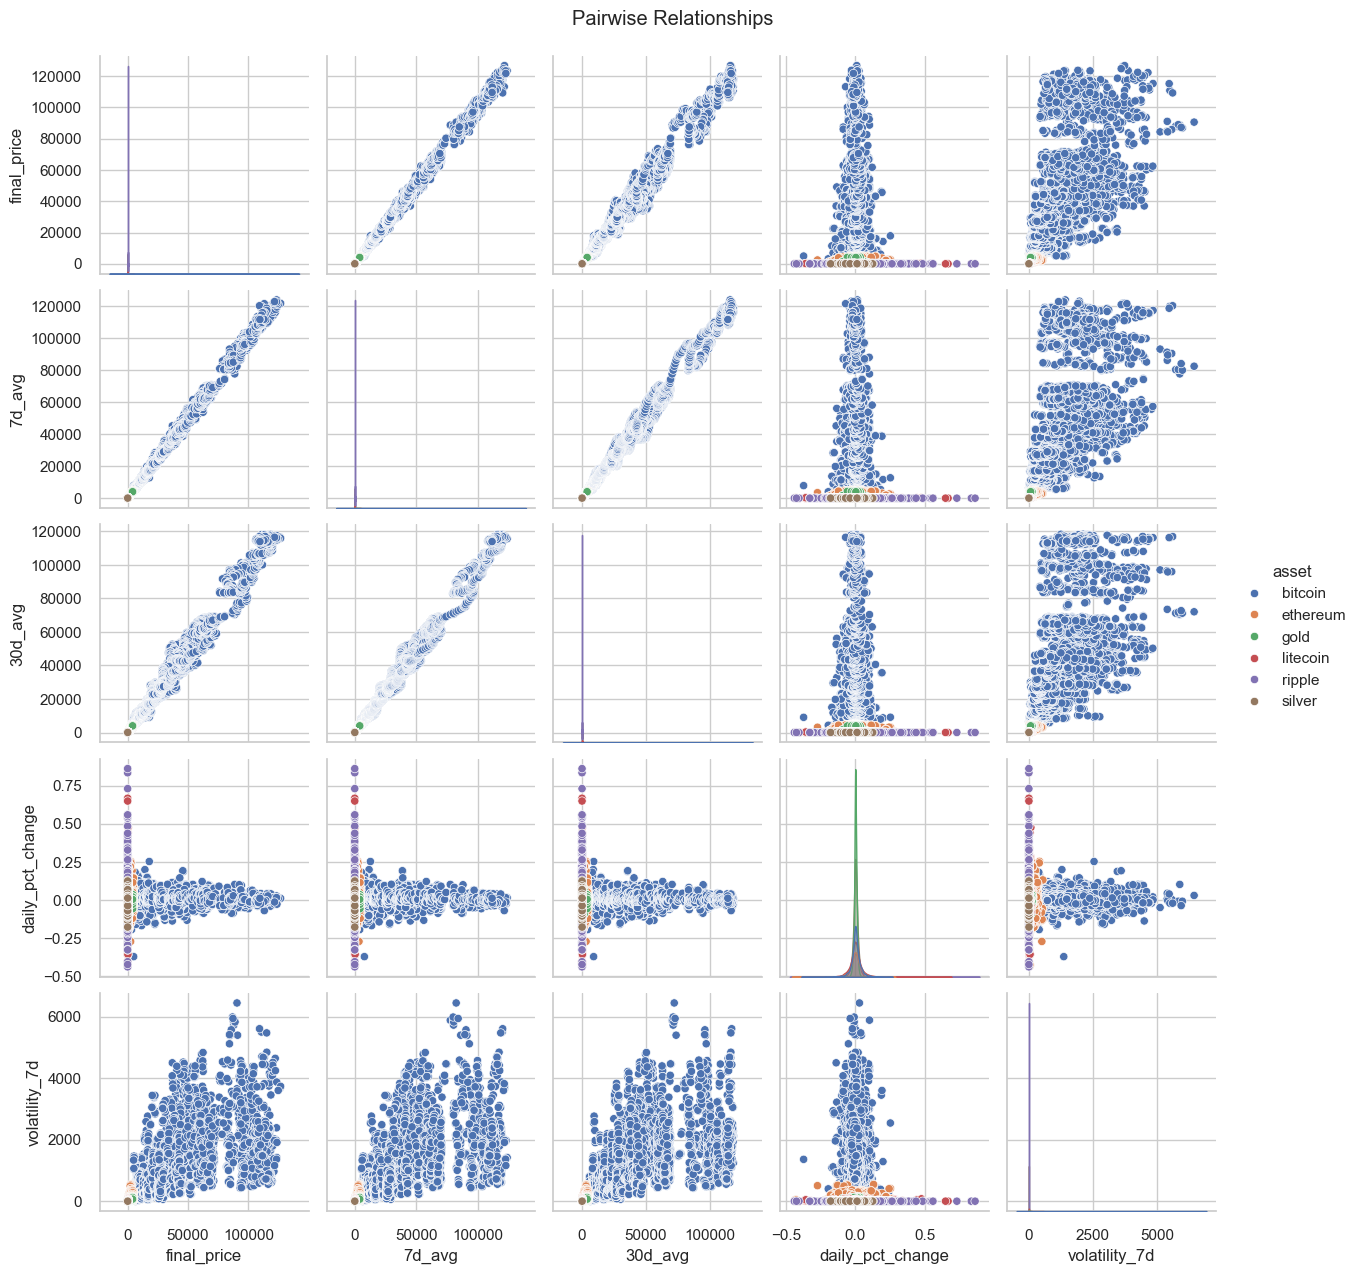

In [76]:
# Pairwise Relationships
sns.pairplot(df, vars=num_cols[:5], hue=hue_col, diag_kind="kde")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()


asset                        bitcoin    ethereum          gold     litecoin  \
final_price      count   7542.000000  5448.00000  11855.000000  7582.000000   
                 mean   25746.173328  1666.93578   1232.062681    71.724846   
                 std    30577.092297  1279.67645    686.436600    59.368734   
                 min      178.100000    84.18000    251.270000     1.160000   
                 25%     2506.395000   361.32500    647.715000    30.220000   
...                              ...         ...           ...          ...   
future_direction min        0.000000     0.00000      0.000000     0.000000   
                 25%        0.000000     0.00000      0.000000     0.000000   
                 50%        1.000000     1.00000      1.000000     1.000000   
                 75%        1.000000     1.00000      1.000000     1.000000   
                 max        1.000000     1.00000      1.000000     1.000000   

asset                        ripple        silver  

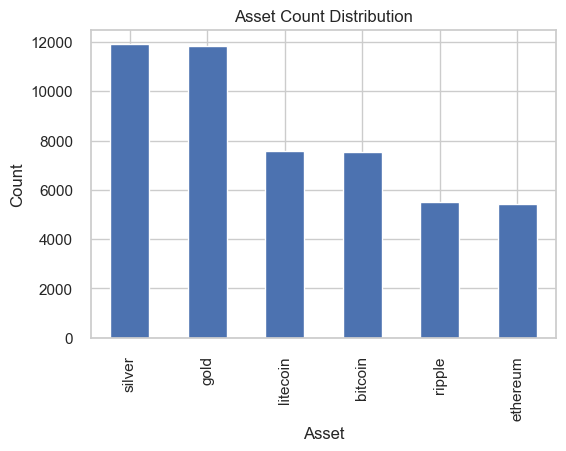

In [71]:
# Descriptive analysis by asset class
group_stats = df.groupby(hue_col)[num_cols].describe().T
print(group_stats)

# Asset count distribution
plt.figure(figsize=(6,4))
df[hue_col].value_counts().plot(kind='bar')
plt.title("Asset Count Distribution")
plt.xlabel("Asset")
plt.ylabel("Count")
plt.show()


In [ ]:
# Here we check the relationship between volatility and return
sns.jointplot(
    data=df,
    x="volatility_7d",
    y="daily_pct_change",
    kind="kde",
    fill=True,
    space=0,
    cmap="viridis"
)
plt.show()

#### Observations:
1. The above KDE jointplot of 'volatility_7d' vs. 'daily_pct_change' shows that most observations cluster around low volatility values and near-zero daily returns, reflecting the typical stability of the majority of days.
2. There is a clear concentration around the origin, suggesting that extreme daily returns are most frequently associated with periods of higher volatility, but these events are rare.
3. Overall, higher volatility does increase the spread of daily returns (both positive and negative), confirming that volatility is a good proxy for risk in these asset classes.
4. No strong asymmetric tail is observed in the density, indicating that there is no major skew in the joint relationship for the sampled data.


In [91]:
# 3-Dimension Distribution (Scatter) by asset classes
from mpl_toolkits.mplot3d import Axes3D

df_plot = df.sample(3000, random_state=42) # Reduce dots
assets = df["asset"].unique()
colors = sns.color_palette("tab10") # readable colors
markers = ["o", "^", "s", "D", "P"]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, asset in enumerate(assets):
    d = df_plot[df_plot["asset"] == asset]

    ax.scatter(
        d["volatility_7d"],
        d["momentum_14d"],
        d["daily_pct_change"],
        color=colors[i],
        marker=markers[i % len(markers)],
        alpha=0.4,
        s=20,
        edgecolors="black",
        linewidth=0.2,
        label=asset,
    )

ax.set_xlabel("volatility_7d")
ax.set_ylabel("momentum_14d")
ax.set_zlabel("daily_pct_change")
ax.set_title("3D Scatter by Asset")

ax.view_init(elev=20, azim=135)

ax.legend()
plt.tight_layout()
plt.show()


#### Observations:
1. Higher short-term volatility generally corresponds with more extreme daily returns, both positive and negative. This reinforces risk theory: assets with elevated volatility are prone to larger swings.
2. Momentum patterning can be different across asset classes, indicating potential differences in how trends persist for each.
3. There’s no universal “winner” asset visible—clusters overlap, so timing and trend-following (rather than blindly picking an asset) appear crucial.

**Investing Takeaways:**

**Risk Management:** Given the clear spread in daily returns with higher volatility, it’s prudent to size positions thoughtfully and use stop-losses or trailing stops when volatility increases.

**Trend Awareness:** Since momentum and volatility interact, strategies that adapt to both (for example, trend-following when both are high, mean reversion when volatility spikes but momentum fades) could be more effective than static allocation.

**Diversification:** The clusters by asset class suggest persistent behavioral differences—diversifying across asset types can help reduce overall risk while participating in distinct market regimes.

**No Guaranteed Outperformer:** No single cluster is universally “dominant”—highlighting that informed entry points and active management are key to success rather than simple buy-and-hold or asset favoritism.


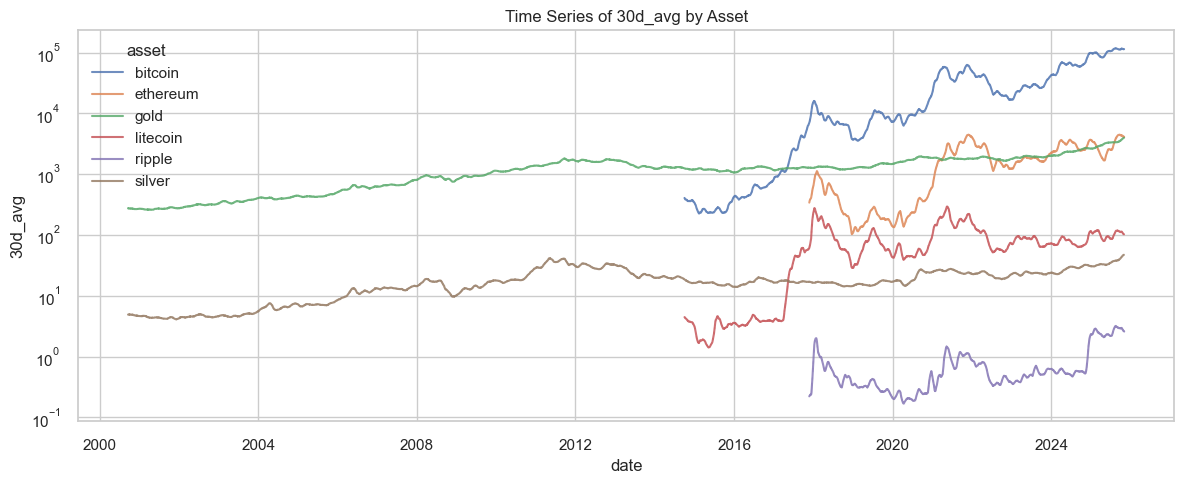

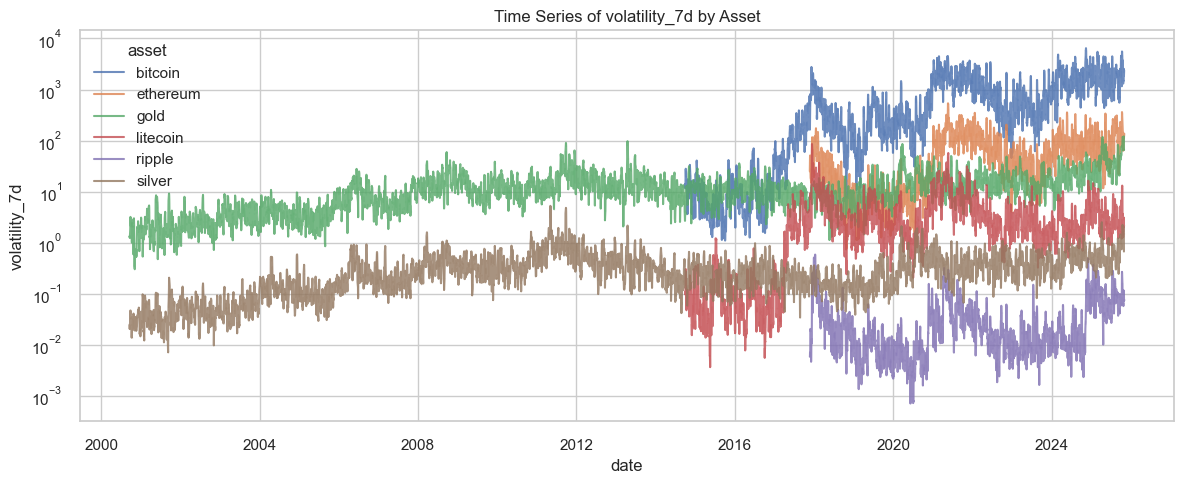

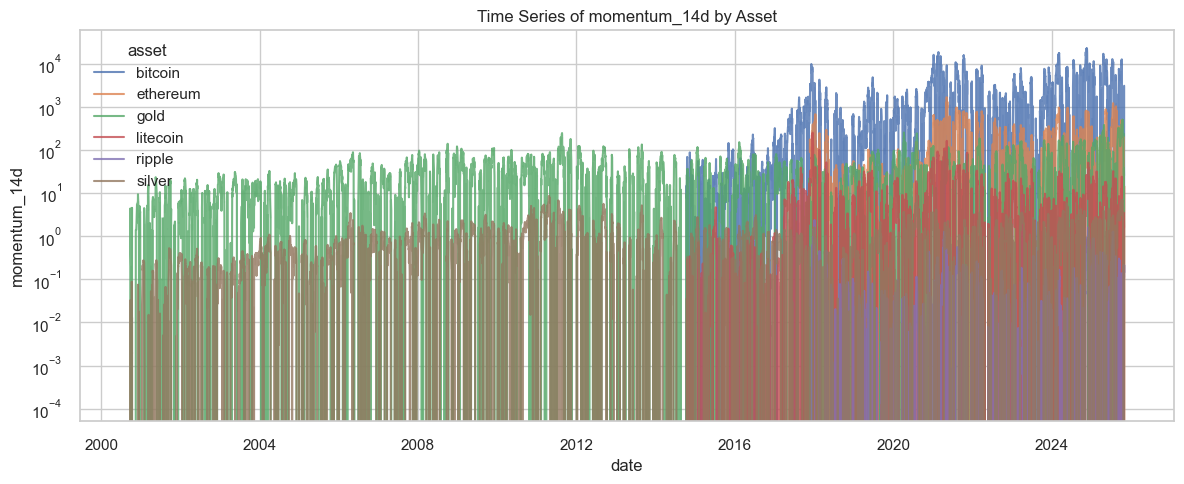

In [93]:
# Time Series (Date)
cols_to_plot = ["7d_avg", "30d_avg", "volatility_7d", "momentum_14d"]

for col in cols_to_plot:
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df, x="date", y=col, hue="asset", alpha=0.8)
    plt.yscale('log')
    plt.title(f"Time Series of {col} by Asset")
    plt.tight_layout()
    plt.show()



The above can reveal:

Whether assets such as gold and silver move in tandem: 

Yes

Whether regime shifts occurr: 

Yes

Which variables exhibit pronounced trend fluctuations over time

**volatility_7d and momentum_14d**

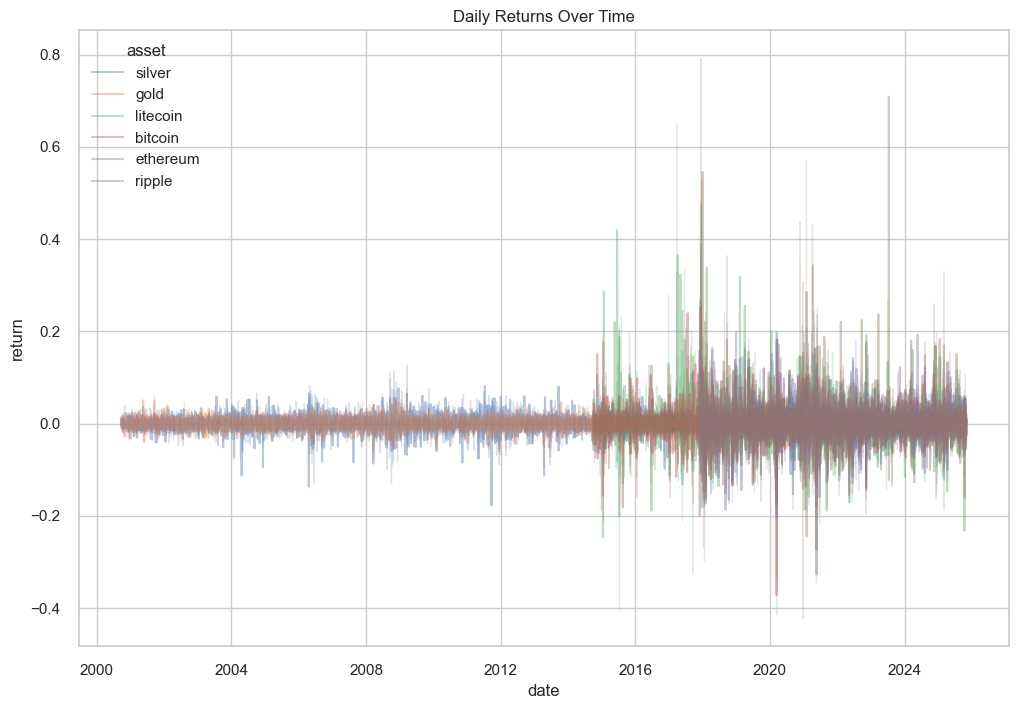

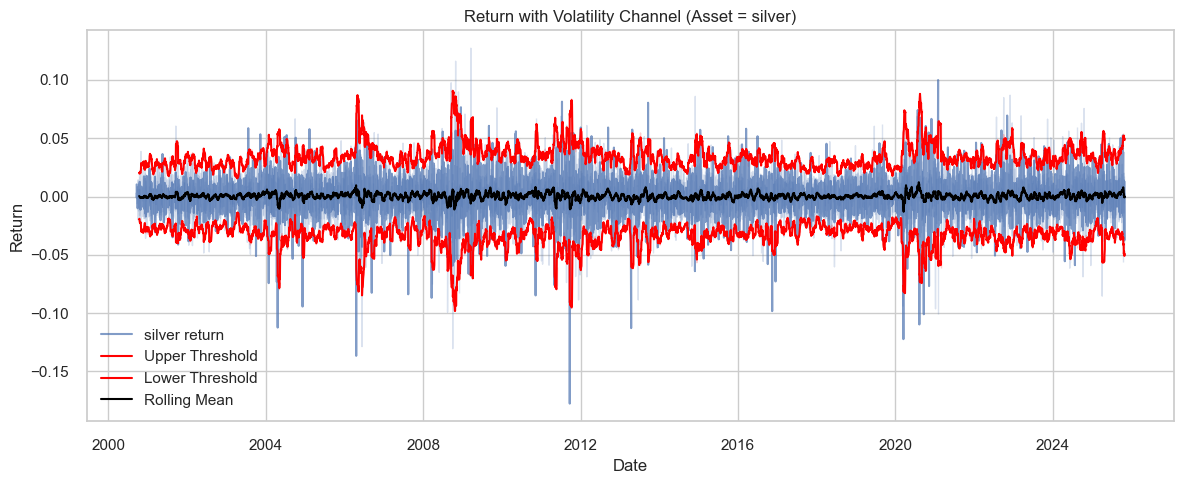

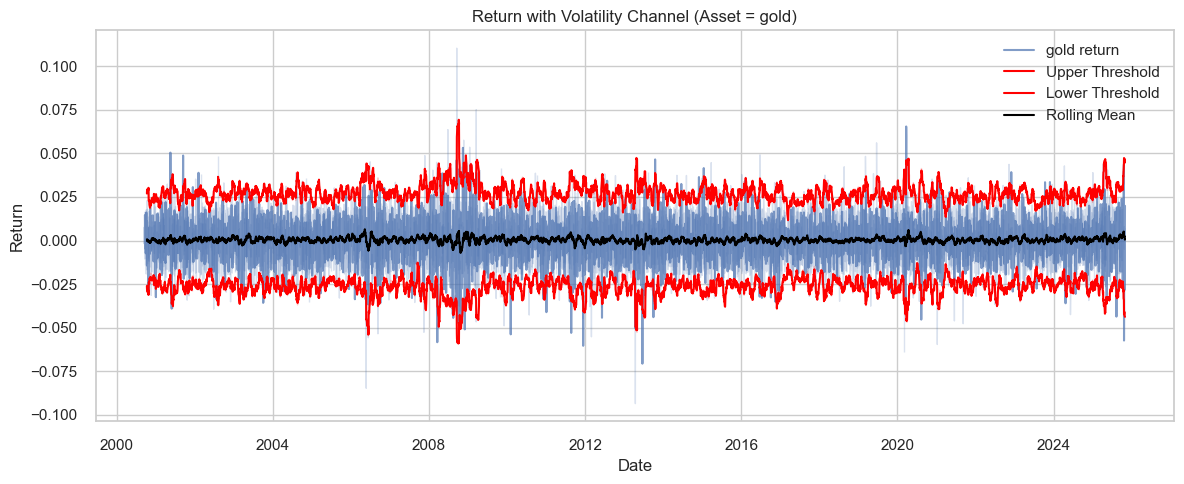

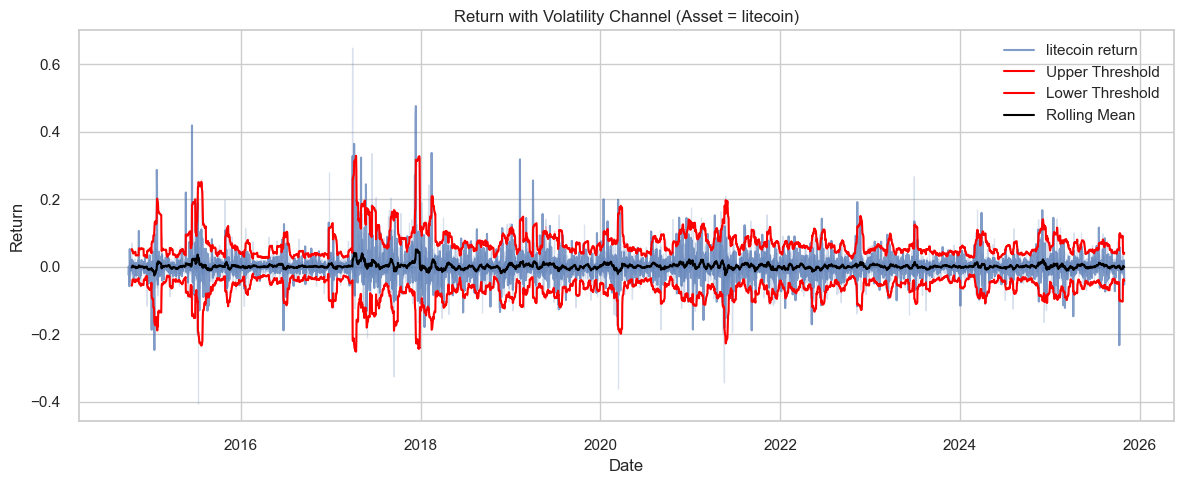

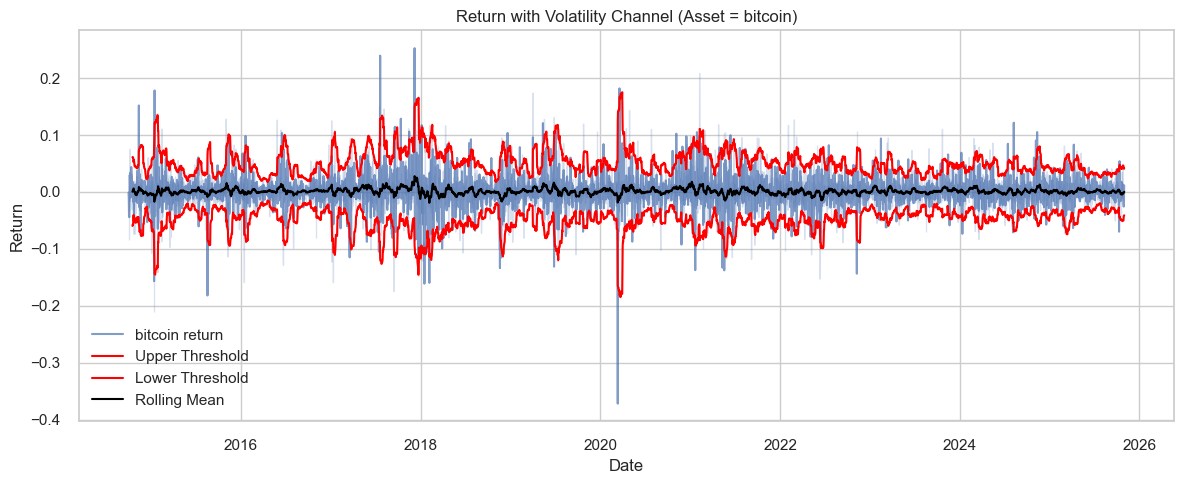

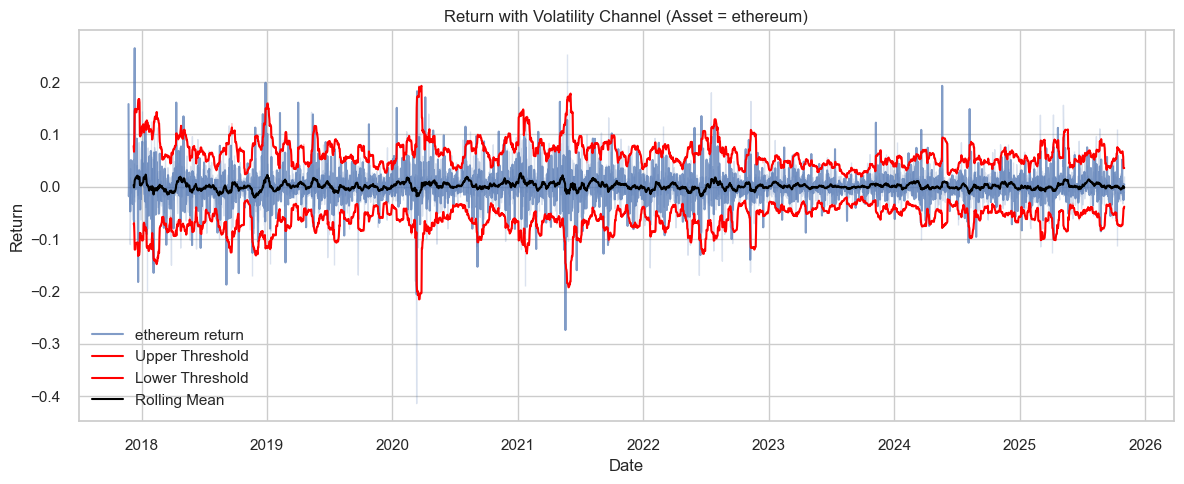

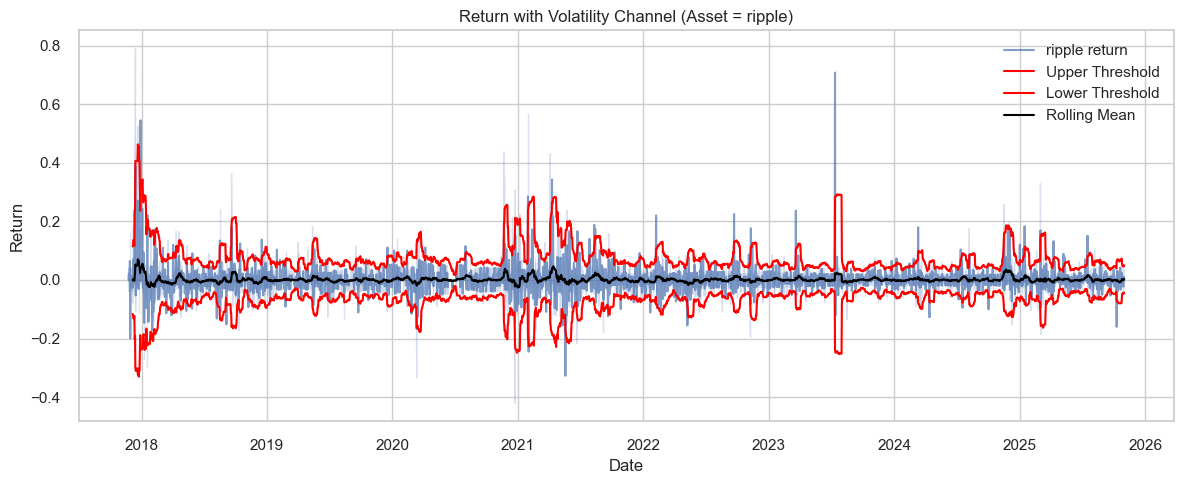

In [113]:
# calculate and visualize the return
df["return"] = df.groupby("asset")["final_price"].pct_change()

plt.figure(figsize=(12,8))
sns.lineplot(data=df, x="date", y="return", hue="asset", alpha=0.40)
plt.title("Daily Returns Over Time")
plt.show()


# with threshold channel
window = 30
k = 2 

df["roll_mean"] = df.groupby("asset")["return"].transform(
    lambda x: x.rolling(window).mean()
)
df["roll_std"] = df.groupby("asset")["return"].transform(
    lambda x: x.rolling(window).std()
)

df["upper"] = df["roll_mean"] + k * df["roll_std"]
df["lower"] = df["roll_mean"] - k * df["roll_std"]

assets = df["asset"].unique()

for asset in assets:
    d = df[df["asset"] == asset]

    plt.figure(figsize=(12, 5))
    sns.lineplot(data=d, x="date", y="return", label=f"{asset} return", alpha=0.7)
    sns.lineplot(data=d, x="date", y="upper", label="Upper Threshold", color="red")
    sns.lineplot(data=d, x="date", y="lower", label="Lower Threshold", color="red")
    sns.lineplot(data=d, x="date", y="roll_mean", label="Rolling Mean", color="black")

    plt.title(f"Return with Volatility Channel (Asset = {asset})")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.tight_layout()
    plt.show()

This return curve with Threshold Channel is suitable for examining abnormal price movements, identifying volatility regimes, and seeking potential reversal points.



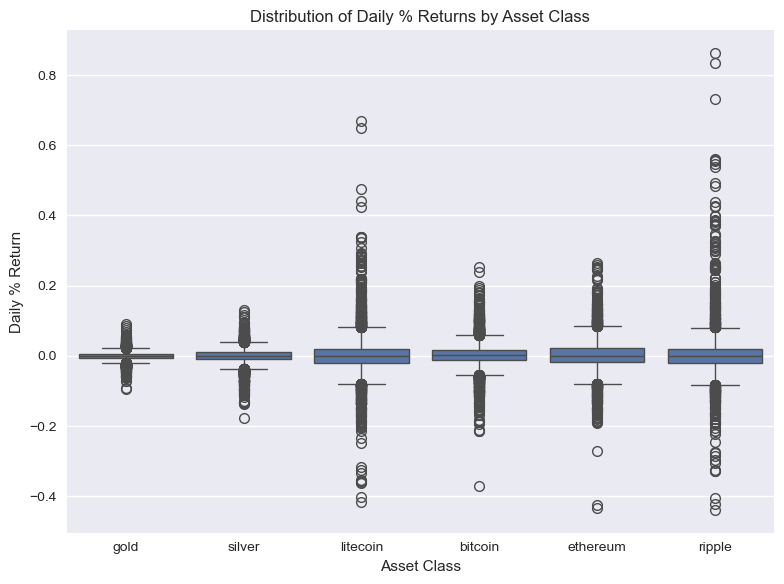

In [134]:
# Boxplots of daily returns by asset class
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="asset", y="daily_pct_change")
plt.title("Distribution of Daily % Returns by Asset Class")
plt.xlabel("Asset Class")
plt.ylabel("Daily % Return")
plt.tight_layout()
plt.show()

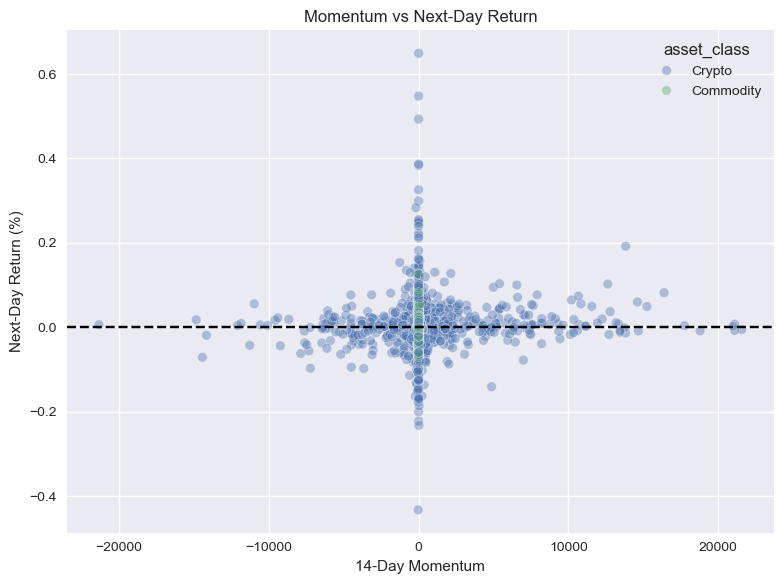

In [143]:
# Momentum vs next-day return
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df.sample(5000, random_state=42),
    x="momentum_14d",
    y="future_return",
    hue="asset_class",
    alpha=0.4
)
plt.title("Momentum vs Next-Day Return")
plt.xlabel("14-Day Momentum")
plt.ylabel("Next-Day Return (%)")
plt.axhline(0, linestyle="--", color="black")
plt.tight_layout()
plt.show()

Now:

 We can see the **price trends** of different assets, with observable **volatility cyclicality** and **regime shifts**

 Besides, the **syhchronization** between commodities are evident (e.g. gold and silver)


# Modeling

In [140]:
features = ["trend_signal", "momentum_14d", "volatility_7d", "price_zscore"]
X = df[features]
y_reg = df["future_return"]
y_clf = df["future_direction"] 

### OLS Regression

In [144]:
import statsmodels.formula.api as smf

ols_formula = "future_return ~ trend_signal + momentum_14d + volatility_7d + price_zscore"
ols_model = smf.ols(ols_formula, data=df).fit()

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          future_return   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     566.3
Date:                Sun, 16 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:31:55   Log-Likelihood:                 95174.
No. Observations:               49839   AIC:                        -1.903e+05
Df Residuals:                   49834   BIC:                        -1.903e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0075      0.000     26.469

### Logistic Regression

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y_clf, test_size=0.25, random_state=42, stratify=df["asset_class"]
)

log_reg = LogisticRegression(max_iter=2000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

acc, roc

(0.5654895666131621, 0.5912193688118812)

### Confusion Matrix

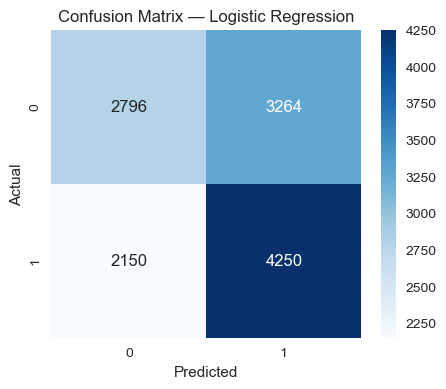

In [146]:
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [147]:
# ===== Time-based split + logistic model for backtest =====

# We already have: X, y_clf, df
# Make sure df is still sorted by ['asset', 'date'] as you did earlier

split_idx = int(len(df) * 0.8)  # use first 80% of time as train, last 20% as test

X_train_time = X.iloc[:split_idx]
X_test_time  = X.iloc[split_idx:]
y_train_time = y_clf.iloc[:split_idx]
y_test_time  = y_clf.iloc[split_idx:]

from sklearn.linear_model import LogisticRegression

log_reg_time = LogisticRegression(max_iter=2000)
log_reg_time.fit(X_train_time, y_train_time)

# Predictions on the time-based test set
y_pred_time  = log_reg_time.predict(X_test_time)
y_proba_time = log_reg_time.predict_proba(X_test_time)[:, 1]

from sklearn.metrics import accuracy_score, roc_auc_score

acc_time = accuracy_score(y_test_time, y_pred_time)
roc_time = roc_auc_score(y_test_time, y_proba_time)

acc_time, roc_time

(0.5709269662921348, 0.5980724763511002)

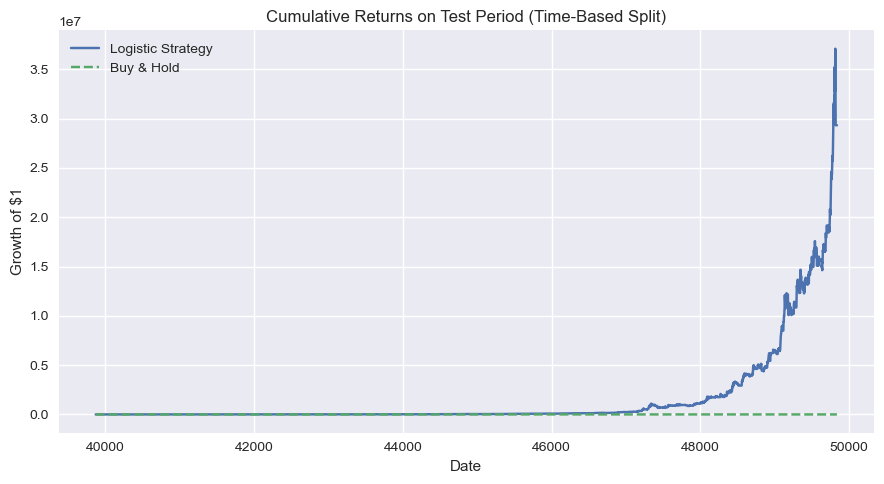

In [148]:
# ===== Simple long/flat strategy backtest =====

# Align future returns with the time-based test set
future_ret_test = df["future_return"].iloc[split_idx:]

# Strategy: go long (position = 1) when model predicts up (1), otherwise stay out (0)
position = pd.Series(y_pred_time, index=future_ret_test.index)  # 1 = long, 0 = flat

strategy_ret = position * future_ret_test  # daily % returns of the strategy
buy_hold_ret = future_ret_test             # "always long" benchmark

# Convert to cumulative growth of 1 unit invested
strategy_cum = (1 + strategy_ret).cumprod()
buy_hold_cum = (1 + buy_hold_ret).cumprod()

plt.figure(figsize=(9, 5))
plt.plot(strategy_cum.index, strategy_cum.values, label="Logistic Strategy")
plt.plot(buy_hold_cum.index, buy_hold_cum.values, label="Buy & Hold", linestyle="--")
plt.title("Cumulative Returns on Test Period (Time-Based Split)")
plt.xlabel("Date")
plt.ylabel("Growth of $1")
plt.legend()
plt.tight_layout()
plt.show()

### Lasso Logistic Regression

In [149]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

lasso = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", solver="liblinear", max_iter=2000)
)

lasso.fit(X_train, y_train)

coef = lasso.named_steps["logisticregression"].coef_[0]
coef_series = pd.Series(coef, index=features)
coef_series

trend_signal    -0.317366
momentum_14d    -0.007173
volatility_7d    0.000781
price_zscore     0.468431
dtype: float64

### Bar Chart: Lasso Coefficients

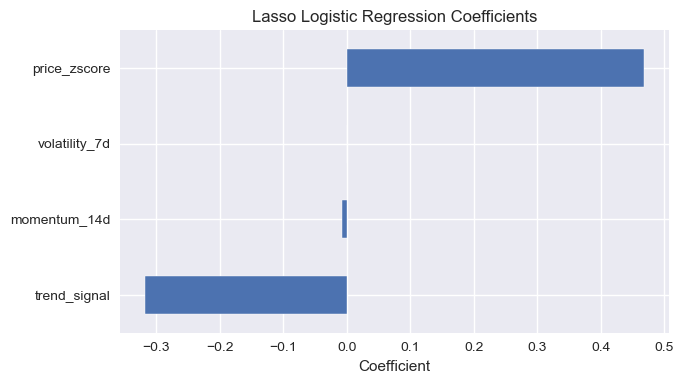

In [150]:
plt.figure(figsize=(7,4))
coef_series.sort_values().plot(kind="barh")
plt.title("Lasso Logistic Regression Coefficients")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

### Crypto vs Commodity: Model Comparison

In [151]:
results = []

for cls in ["Crypto", "Commodity"]:
    df_sub = df[df["asset_class"] == cls]
    
    X_sub = df_sub[features]
    y_sub = df_sub["future_direction"]
    
    X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
        X_sub, y_sub, test_size=0.25, random_state=42
    )
    
    model = LogisticRegression(max_iter=2000)
    model.fit(X_train_sub, y_train_sub)
    
    y_pred_sub = model.predict(X_test_sub)
    y_proba_sub = model.predict_proba(X_test_sub)[:, 1]
    
    results.append({
        "Asset Class": cls,
        "Accuracy": accuracy_score(y_test_sub, y_pred_sub),
        "ROC AUC": roc_auc_score(y_test_sub, y_proba_sub)
    })

results_df = pd.DataFrame(results)
results_df

Asset Class  Accuracy   ROC AUC
0      Crypto  0.561743  0.585748
1   Commodity  0.563878  0.586161

### Bar Plot: Crypto vs Commodity Performance

<Figure size 700x500 with 0 Axes>

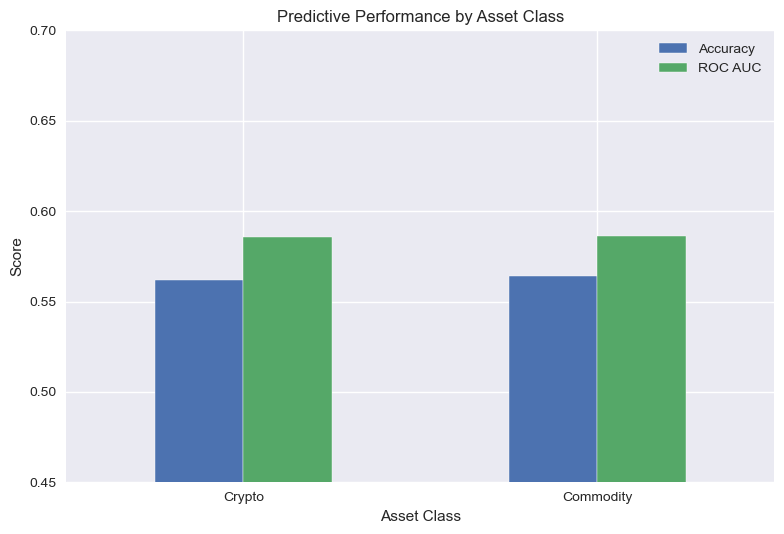

In [152]:
plt.figure(figsize=(7,5))
results_df.plot(x="Asset Class", y=["Accuracy", "ROC AUC"], kind="bar")
plt.title("Predictive Performance by Asset Class")
plt.ylim(0.45, 0.70)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()